# Table of Contents
  * [Chapter 1](#chapter-1)
  * [Analizing Data](#analizing-data)
  * [Chapter 3](#chapter-3)

# Sending the packets

To change the datarate and the txpower in the router, ssh into it and run the following commands

```bash
# To change the data rate
wl rate 11

# To change the power
wl txpwr1 -m 60 # mW
# Or in dBm in steps of 0.25
wl txpwr1 17.75 # 60 mW

# To check the transission power
wl txpwrlimit
```

All the available commands are here: http://www.dd-wrt.com/wiki/index.php/Wl_command

## Broadcast case:

A raspberry pi is broadcasting or unicasting packets which payloads consisting on just 0 bits

The code for broadcasting is;

```python
# Send UDP broadcast packets

import sys, time, array, os
from socket import *

rates = ['1', '2', '5.5', '6', '9', '11', '12', '18', '24', '36', '48', '54']
rates_i = 0
MYPORT = 53524
# dest_ip = '<broadcast>'
# My pc
# dest_ip = '192.168.1.124'
# Measurements PC
dest_ip = '192.168.1.130'
data = "0"*2500 # n/2 * 8 [bits] in total

def change_ap_rate ():
    global rates_i
    global rates
    rate = rates[rates_i]
    command = 'ssh root@192.168.1.1 \'wl rate ' + rate + '\''
    os.popen(command)
    print ('Changing rate to {}Mbps'.format(rate) + ' using the following command '  + command)
    # Increase the index for the next function call
    rates_i += 1
    if rates_i >= len(rates):
        rates_i = 0

# Check if n minute passed
def has_minutes_passed(oldepoch,n):
    return time.time() - oldepoch >= n*60

def main():
    # Initialize the rate to 1 Mbps
    change_ap_rate()
    pkts_sent = 0
    oldepoch = time.time()
    s = socket(AF_INET, SOCK_DGRAM)
    s.bind(('', 0))
    s.setsockopt(SOL_SOCKET, SO_BROADCAST, 1)
    global data
    data= data.decode('hex')

    while 1:
        s.sendto(data, (dest_ip, MYPORT))
        pkts_sent += 1
        #print data
        # 5 minutes passed
        if (has_minutes_passed(oldepoch,5)):
            oldepoch = time.time()
            print (pkts_sent)
            pkts_sent = 0
            change_ap_rate()

        time.sleep(0.05)
        #break

if __name__ == "__main__":
    main()
```

# Capturing the packets

To capture the packets it is needed to set the NIC in monitor mode. The instructions are [here](https://sandilands.info/sgordon/capturing-wifi-in-monitor-mode-with-iw)

## Setting up the monitor interface

The only special consideration is that you need to include the flag for capturing packets with the FCS fail:

```bash
sudo iw phy phy0 interface add mon0 type monitor flags fcsfail
```

I do the following when using the USB dongle

```bash
sudo iw phy phy1 interface add mon0 type monitor flags fcsfail
sudo iw dev wlp0s26u1u2 del
sudo ifconfig mon0 up
# Set it to channel 6
sudo iw dev mon0 set freq 2437
```

### Troubleshooting: type doesn't change to monitor from managed

If the type does not change, it is most likely because network manager is controlling the interface. For solving this, one must remove the interface from the `/etc/NetworkManager/NetworkManager.conf` file.

Add these lines to said file:

```
[main]
plugins=keyfile

[keyfile]
unmanaged-devices=mac:xx:xx:xx:xx:xx:xx
```

The correct MAC address can be found running the command `iw dev`

## Tshark for packet capturing

The script used for capturing the packets is the following
```bash
if [ "$#" -ne 2 ]; then
    echo "Input the mw and the data rate as arguments"
    echo "Usage: ./capture.sh xx yy"
    echo "xx: mw"
    echo "yy: mbps"
    exit 1
fi

tshark -i mon0 -f "udp && host 192.168.1.144 && port 53524" \
    -w "$(date +%F_%H_%M)_$1mw_$2mbps.pcapng" -T fields -E separator=' ; ' \
    -e wlan.fcs_bad -e radiotap.dbm_antsignal -e radiotap.datarate
```

* -i interface
* -f is the capture filter (we only want to capture the UDP packets sent from the raspi)
* -w name of the output file
* -T We want to display some packets fields in console
* -e specify which fields (fcs broken and signal strength in dBm)

# Analyzing the data <a id="analizing-data"></a>

In [190]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()

import pyshark
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
# import binascii
import timeit
import os

Some constants

In [45]:
# TOTAL_BITS = 400
TOTAL_BITS = 10000
AP_MAC = '58:6d:8f:d3:5e:70'

## Loading the captured packets

In [28]:
# file = 'test_capture.pcapng'
# file = 'gvsp.pcapng'
# file = 'bigger test.pcapng'
# file = 'test_for_weekend.pcapng'
# file = '30-11-15_54mbps_1mw.pcapng'
# file = '2015-12-04_17_25.pcapng' # Testing automated measurements
# file = '2015-12-07_11_51.pcapng' # Test across the rooms
# file = '2015-12-09_14_36_60mw_manymbps.pcapng' # First automated test
file = '2015-12-09_17_12_60mw_all_nightmbps.pcapng' # Big automated




cap = pyshark.FileCapture(file)

## Extracting information

### Filter the CRC broken packets

In [29]:
# Lets measure the time it takes to complete this
start_time = timeit.default_timer()

broken_pkts = [pkt for pkt in cap if pkt.wlan.fcs_bad == '1']

print ('Time taken: {} seconds'.format(timeit.default_timer() - start_time))

total_broken_pkts = len(broken_pkts)

Time taken: 1045.655026769 seconds


#### Make a dataframe with all the files

We use pandas to build the data frame with some usefull columns:

In [46]:
# Broken data as a string
data = []
data_rate = []
rssi = []
tx_mac = []
is_broken = []
for pkt in broken_pkts:
# for pkt in pkts:
    # Data
    try:
        data.append(pkt.data.data.replace(':',''))
    except(AttributeError):
        continue
    # Data rate
    try:
        data_rate.append(float(pkt.radiotap.datarate))
    except:
        data.pop()
        continue
    # RSSI
    try:
        rssi.append(int(pkt.radiotap.dbm_antsignal))
    except:
        data.pop()
        data_rate.pop()
        continue
    # Transmitter MAC Address
    try:
        tx_mac.append(pkt.wlan.ta)
    except:
        data.pop()
        data_rate.pop()
        rssi.pop()
        continue
    # CRC failed
    try:
        is_broken.append(bool(pkt.wlan.fcs_bad))
    except:
        data.pop()
        data_rate.pop()
        rssi.pop()
        tx_mac.pop()
        continue

fields={'Data':data,'Data_rate':data_rate,'RSSI':rssi,'Tx_mac':tx_mac,'Broken':is_broken}
p_data = pd.DataFrame(fields)
# ==========

# Add a column stating if the AP sent the packet
p_data['AP_pkt'] = p_data['Tx_mac'].apply(lambda x: x == '58:6d:8f:d3:5e:70')
# ==========


# Add a column with Binary Data
def str2bin(number):
    decimal_number = int(number,16)
    # Do not return the '0b' at the beginning and fill with zeroes
    return bin(decimal_number)[2:].zfill(8)

def data_to_bin(data):
    return [str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)]

def bytes_to_binarray(list_of_bytes):
    temp_str = ''
    for byte in list_of_bytes:
        temp_str = temp_str + byte
    return temp_str

p_data['Data_bin'] = p_data['Data'].apply(data_to_bin)
p_data['Data_bin'] = p_data['Data_bin'].apply(bytes_to_binarray)
# ==========

# Add a column stating if the data has the right length
# p_data['Right_Length'] = p_data['Data'].apply(lambda x: len(x) == 100)
p_data['Right_Length'] = p_data['Data_bin'].apply(lambda x: len(x) == TOTAL_BITS)
# ==========

# Add column with number of bits flipped
p_data['Flipped_bits'] = p_data['Data_bin'].apply(lambda x: x.count('1'))
# ==========

# Save DF
p_data.to_msgpack('test.msg')
# ==========

In [31]:
# If we saved the dataframe, we can load it here
# p_data = pd.read_msgpack('across_rooms_day2_30_mins_each.msg')

Count the number of packets with the right and wrong length

In [47]:
# Group the packets in right/wrong length and count the number of occurences
lengths = p_data.groupby(['Right_Length']).size()
print(lengths)
# Right length
total_broken_pkts_true_length = lengths[True]

# Wrong length
total_broken_pkts_false_length = lengths[False]

Right_Length
False      982
True     27954
dtype: int64


### Percentage of broken packets

In [48]:
# # Total packets captured sent from the AP
# # We get this number doing a system call to tshark: tshark -r 2015-12-07_11_51.pcapng -Y 'wlan.ta==58:6d:8f:d3:5e:70 && wlan.fcs_bad==true' | wc -l
command = 'tshark -r ' + file + ' -Y \'wlan.ta==' + AP_MAC + '\' | wc -l'
total_pkts_AP = np.int64(os.popen(command).read())

# Percentage of useful broken packets. I.e., *Sent from AP; *Correct length; *IP from Raspi (@capture time); *Right port (@capture time)
total_useful_broken_packets = np.int64(len(p_data[(p_data['Right_Length'] == True) &(p_data['AP_pkt'] == True)].index))
percentage_broken_pkts = total_useful_broken_packets / total_pkts_AP *100

print ("Percentage of broken packets = {}".format(percentage_broken_pkts))

# Extract all the measured data rates
data_rates = pd.unique(p_data[p_data['AP_pkt'] == True].Data_rate.ravel())

# total_pkts_AP = np.int64(0)
# for file in file_list:
#     # Total packets captured sent from the AP
#     # We get this number doing a system call to tshark: tshark -r 2015-12-07_11_51.pcapng -Y 'wlan.ta==58:6d:8f:d3:5e:70 && wlan.fcs_bad==true' | wc -l
#     command = 'tshark -r ' + file + ' -Y \'wlan.ta==' + AP_MAC + '\' | wc -l'
#     print (command)
#     total_pkts_AP += np.int64(os.popen(command).read())

# percentage_broken_pkts = total_useful_broken_packets / total_pkts_AP *100
# print ("Percentage of broken packets = {}".format(percentage_broken_pkts))
# total_pkts_AP

Percentage of broken packets = 19.24734794413189


In [81]:
total_pkts_AP

142908

## Bits flipped

Create a vector containing the number of bits flipped in specific locations

In [107]:
# Empty vector
total_flips_occurences = [0]*TOTAL_BITS

# Operate only over data packets of the right size
right_size_data = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)]['Data_bin']

for row in right_size_data:
    # Traverse the vector
    for i,x in enumerate(row):
        # If the value is a '1' add one to the vector of flips_occurences
        if x == '1':
            total_flips_occurences[i] = total_flips_occurences[i] + 1

Plot flip ocurrences

In [108]:
fig = plt.figure()
plt.plot(range(len(total_flips_occurences)),total_flips_occurences / total_useful_broken_packets)
plt.show()

### Multiple plots

In [159]:
def flips_counter(rr):
    flips = [0]*TOTAL_BITS
    for row in rr['Data_bin']:
        # Traverse the vector
        for i,x in enumerate(row):
            # If the value is a '1' add one to the vector of flips_occurences
            if x == '1':
                flips[i] = flips[i] + 1
    return flips

# For packets coming from the AP and with the right length count the number of bits flipped
flips_occurences = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)][['Data_bin','Data_rate']]
flips_occurences = flips_occurences.groupby('Data_rate').apply(flips_counter)

# Calculate the useful packets per data rate
useful_broken_packets = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)].groupby('Data_rate').size()
# ========

# Normalize the number of bits flipped by the total useful broken packets at that data rate
flips_occurences_norm[:] = flips_occurences
it = 0
for row in flips_occurences:
    flips_occurences_norm.loc[data_rates[it]] = row / useful_broken_packets.loc[data_rates[it]]
    it += 1
flips_occurences_norm
# ========

o = []
for i in flips_occurences_norm.values:
    o.append(i)
o=np.transpose(o)
# ax = fig.add_subplot(54,400,1, projection='3d')
X, Y = np.meshgrid(data_rates, range(TOTAL_BITS))

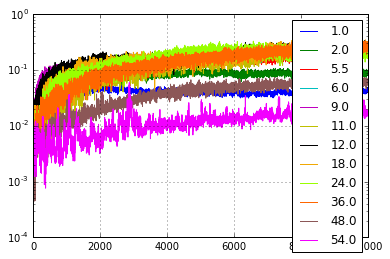

In [191]:
def get_color():
    for item in ('b','g','r','c','m','y','k','#F0A804','#99FF00','#FF6600','#8C5757','#F200FF','#808080'):
        yield item

color = get_color()
fig = plt.figure()
seq = np.arange(TOTAL_BITS)
for row in flips_occurences_norm:
    acolor = next(color)
    plt.semilogy(seq,row,acolor)

plt.legend(data_rates.astype('str'))
plt.grid()

3d plots

In [165]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(Y, X, o, rstride=0, cstride=1, antialiased=True)
plt.grid()
plt.show()

### Average number of flipped bits

In [161]:
avrg_number_flipped_bits = p_data[(p_data['Right_Length'] == True) & (p_data['AP_pkt'] == True)][['Flipped_bits','Data_rate']]
avrg_number_flipped_bits = avrg_number_flipped_bits.groupby('Data_rate').mean()
avrg_number_flipped_bits.columns=['Avrg_flipped_bits']
avrg_number_flipped_bits

Avrg_flipped_bits
Data_rate                   
1.0               388.525672
2.0               752.591286
5.5              1293.288136
6.0              1459.070833
9.0              1735.692691
11.0             1357.676301
12.0             1811.050360
18.0             1694.815385
24.0             1685.495370
36.0             1563.346405
48.0              406.518149
54.0              124.142564

# =========================================================
### Cells for testing code
# =========================================================

In [ ]:
p_data

# =========================================================
### Deprecated
# =========================================================

Get the broken data from the packets as a string, hex values and binary array <span style="color:red;">(Deprecated, it's done with Pandas now)</span> 

In [ ]:
# # Broken data as a string
# broken_data = [pkt.data.data for pkt in broken_pkts]


# # filter out packets that have the wrong data length
# broken_data = [x for x in broken_data if len(x) == 100]
# total_broken_pkts_true_length = len(broken_data)
# total_broken_pkts_false_length = total_broken_pkts - total_broken_pkts_true_length

# # # Broken data as hex values
# # hex_broken_data=[]
# # count = 0
# # for data in broken_data:
# #     hex_broken_data.append([binascii.a2b_hex(data[byte:byte+2]) for byte in range(0, len(data),2)])
# #     #print(byte)
# #     count=count+1
    
# # Broken data as binary values
# def str2bin(number):
#     decimal_number = int(number,16)
#     # Do not return the '0b' at the beginning and fill with zeroes
#     return bin(decimal_number)[2:].zfill(8)
# bin_broken_data = []
# for data in broken_data:
#     bin_broken_data.append([str2bin(data[byte : byte+2]) for byte in range(0, len(data),2)])




Build a single array of bits per broken data  <span style="color:red;">(Deprecated, it's done with Pandas now)</span> 

In [ ]:
# temp = []
# temp_str = ''
# for data in bin_broken_data:
#     for byte in data:
#         temp_str = temp_str + byte
#     temp.append(temp_str)
#     temp_str=''

# bin_broken_data = temp

In [7]:
# file_list = ['2015-12-07_16_31_60mw_1mbps.pcapng', '2015-12-07_17_04_60mw_9mbps.pcapng',
#              '2015-12-07_17_36_60mw_18mbps.pcapng', '2015-12-07_18_11_60mw_36mbps.pcapng',
#              '2015-12-07_18_55_60mw_54mbps.pcapng']

# file_list = ['2015-12-08_14_51_60mw_1mbps.pcapng', '2015-12-08_15_26_60mw_55mbps.pcapng',
#              '2015-12-08_14_14_60mw_9mbps.pcapng', '2015-12-08_16_00_60mw_12mbps.pcapng',
#              '2015-12-08_13_38_60mw_18mbps.pcapng', '2015-12-08_12_48_60mw_36mbps.pcapng',
#              '2015-12-08_11_59_60mw_54mbps.pcapng']

# start_time = timeit.default_timer()

# broken_pkts = []
# for pcap in file_list:
#     print("reading file: " + pcap)
#     cap = pyshark.FileCapture(pcap)
#     for pkt in cap:
#         if pkt.wlan.fcs_bad == '1':
#             broken_pkts.append(pkt)

# print ('Time taken: {} seconds'.format(timeit.default_timer() - start_time))

# total_broken_pkts = len(broken_pkts)

In [123]:
p_data.to_msgpack('across_rooms_automated.msg')